              precision    recall  f1-score   support

           0       0.98      0.58      0.73       982
           1       0.01      0.28      0.02        18

    accuracy                           0.57      1000
   macro avg       0.49      0.43      0.37      1000
weighted avg       0.96      0.57      0.71      1000

ROC AUC: 0.4512898845892736


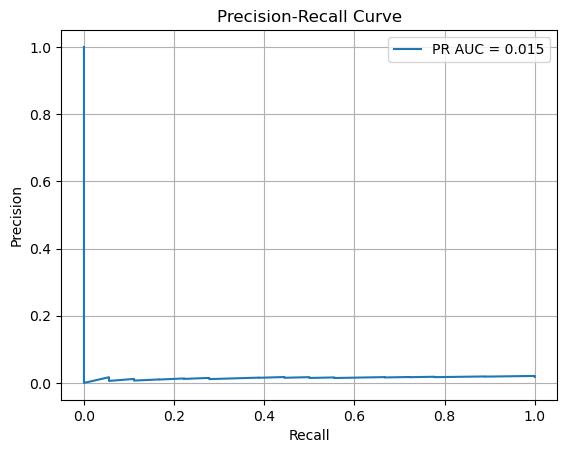

In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.feature_selection import mutual_info_classif
from imblearn.combine import SMOTETomek

# 2. Load Data
df = pd.read_csv("synth_rare_event_data.csv")  # Replace with your file path
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
target_col = "rare_event"

# 3. Preprocess
df = df.dropna(subset=[target_col])
X = df.drop(columns=[target_col])
y = df[target_col]

for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

# 4. Mutual Info Feature Selection
mi = mutual_info_classif(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
top_features = mi_series.head(15).index.tolist()
X = X[top_features]

# 5. Train-Test Split (before resampling)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 6. SMOTETomek Resampling
X_train_bal, y_train_bal = SMOTETomek(random_state=42).fit_resample(X_train, y_train)

# 7. ElasticNet (Logistic Regression)
model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000, random_state=42)
model.fit(X_train_bal, y_train_bal)

# 8. Evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()